# Assignment 3 - Q3 GAN

In [0]:
import torch
from torch import nn
import torchvision
from torch.autograd import  Variable
from torch import optim
from classify_svhn import get_data_loader

import GAN  # needed to allow the reload
import importlib
importlib.reload(GAN)
from GAN import Generator, Discriminator, DGAN_initialization

import matplotlib.pyplot as plt

MODEL_PATH = "GAN_model/"
SAMPLE_PAT = "GAN_sample/"

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)
    
if not os.path.exists(SAMPLE_PAT):
    os.mkdir(SAMPLE_PAT)

lr = 0.0002
betas = (0.5, 0.999)
batch_size = 128
z_size = 100
im_size = 32
n_critic = 5
num_epoch = 50

if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Running on cpu")
    device = torch.device("cpu")
    
G = Generator(z_size).to(device)
D = Discriminator(im_size, device).to(device)

DGAN_initialization(G)
DGAN_initialization(D)

g_optim = optim.Adam(G.parameters(), lr=lr, betas=betas)
d_optim = optim.Adam(D.parameters(), lr=lr, betas=betas)

Using cuda


## Data

In [0]:
train_loader, valid_loader, test_loader = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


tensor(1)


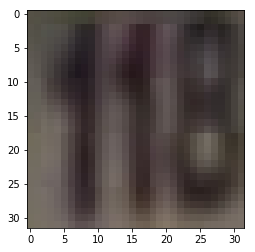

In [0]:
def showImg(x):
  x = x[0] # we take the first element of the batch
  x = x.permute(1, 2, 0)
  plt.imshow((x.detach().cpu().numpy() * 0.5) + 0.5)
    
def saveImg(x, path):
  x = x * 0.5 + 0.5
  torchvision.utils.save_image(x, path)
    
# Show an image
real_sample, target = next(iter(train_loader))

showImg(real_sample)
print(target[0])

In [0]:
def loadModel(modelPath):
  checkpoint = torch.load(modelPath)
  G.load_state_dict(checkpoint['generator_state_dict'])
  g_optim.load_state_dict(checkpoint['generator_optimizer_state_dict'])
  D.load_state_dict(checkpoint['discriminator_state_dict'])
  d_optim.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])


In [0]:

def createSample(generator, name, z, show=False):
    generator.eval()
    
    im = generator(z)
    saveImg(im, name)
    
    if show:
      showImg(im)
    

## Training

In [0]:
def train(loader):
    
    z_sample = Variable(torch.randn(6, z_size, device=device))
    for epoch in range(num_epoch):
        d_train_loss = 0
        for data_idx, real_sample in enumerate(loader):
            G.train()
            D.train()
            
            step = epoch * len(loader) + data_idx + 1
            
            # Train more the dicriminator
            d_optim.zero_grad()
            g_optim.zero_grad()
    
            z = Variable(torch.randn(real_sample[0].shape[0], z_size, device=device))
            
            fake_sample = G(z)
            real_sample = real_sample[0].to(device)
            
            d_loss = D.loss(real_sample, fake_sample)
            d_loss.backward()
            d_train_loss += d_loss.item()
            d_optim.step()
    
            if step % n_critic == 0:
                # Train the generator
                d_optim.zero_grad()
                g_optim.zero_grad()
            
                z = Variable(torch.randn(batch_size, z_size, device=device))
            
                fake_sample = G(z)
                fake_result = D(fake_sample)
                g_loss = G.loss(fake_result)
                g_loss.backward()
                g_optim.step()
                
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, d_train_loss / len(loader.dataset)))
        
        # Save model
        model_name = "GAN_" + str(epoch) + ".pt"
        torch.save({
            'epoch': epoch,
            'generator_state_dict': G.state_dict(),
            'generator_optimizer_state_dict': g_optim.state_dict(),
            'discriminator_state_dict': D.state_dict(),
            'discriminator_optimizer_state_dict': d_optim.state_dict(),
            'loss': d_train_loss / len(loader.dataset)
            }, MODEL_PATH + model_name)
        
        sample_name = 'GAN_' + str(epoch) + '.jpg'
        createSample(G, SAMPLE_PATH+sample_name, z_sample)

In [0]:
train(train_loader)

====> Epoch: 0 Average loss: 0.0171
====> Epoch: 1 Average loss: -0.0141
====> Epoch: 2 Average loss: -0.0146
====> Epoch: 3 Average loss: -0.0148
====> Epoch: 4 Average loss: -0.0153
====> Epoch: 5 Average loss: -0.0154
====> Epoch: 6 Average loss: -0.0151
====> Epoch: 7 Average loss: -0.0169
====> Epoch: 8 Average loss: -0.0189
====> Epoch: 9 Average loss: -0.0196
====> Epoch: 10 Average loss: -0.0194
====> Epoch: 11 Average loss: -0.0191
====> Epoch: 12 Average loss: -0.0181
====> Epoch: 13 Average loss: -0.0174
====> Epoch: 14 Average loss: -0.0174
====> Epoch: 15 Average loss: -0.0170
====> Epoch: 16 Average loss: -0.0167
====> Epoch: 17 Average loss: -0.0163
====> Epoch: 18 Average loss: -0.0162
====> Epoch: 19 Average loss: -0.0160
====> Epoch: 20 Average loss: -0.0159
====> Epoch: 21 Average loss: -0.0158
====> Epoch: 22 Average loss: -0.0155
====> Epoch: 23 Average loss: -0.0155
====> Epoch: 24 Average loss: -0.0154
====> Epoch: 25 Average loss: -0.0151
====> Epoch: 26 Average

## Generate sample

In [0]:
loadModel('GAN.pt')
G.eval()

Generator(
  (linear): Linear(in_features=100, out_features=256, bias=True)
  (linear_activation): ELU(alpha=1.0)
  (conv_stack): Sequential(
    (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
    (1): ELU(alpha=1.0)
    (2): UpsamplingBilinear2d(scale_factor=2, mode=bilinear)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): ELU(alpha=1.0)
    (5): UpsamplingBilinear2d(scale_factor=2, mode=bilinear)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (dgan_conv_stack): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [0]:
for i in range(1000):
  z_sample = Variable(torch.randn(1, z_size, device=device))
  createSample(G, 'GAN_1000/{0:03d}.jpg'.format(i), z_sample)

## Latent variable perturbation

In [0]:
# sample latent variable
latent_variables = Variable(torch.randn(1, z_size, device=device))
createSample(G, 'GAN_perturbation/original.png', latent_variables)

In [0]:
# Make perturbation on all dim and save

for i in range(z_size):
  perturbed_latent_variables = latent_variables.clone()
  if perturbed_latent_variables[0, i] < 0:
      perturbed_latent_variables[0, i] += 3
  else:
      perturbed_latent_variables[0, i] -= 3
  createSample(G, 'GAN_perturbation/dim_{0:03d}.png'.format(i), perturbed_latent_variables)

In [0]:
# perturbate chosen dimensions
strongest_dimensions = [3, 8, 10, 11, 18, 20, 43, 76, 84, 95]
for i in strongest_dimensions:
    perturbed_latent_variables_1 = latent_variables.clone()
    perturbed_latent_variables_2 = latent_variables.clone()
    perturbed_latent_variables_1[0, i] -= 3
    perturbed_latent_variables_2[0, i] += 3
    createSample(G, 'GAN_perturbation/best_dim_{0:03d}_inf.png'.format(i), perturbed_latent_variables_1)
    createSample(G, 'GAN_perturbation/best_dim_{0:03d}_sup.png'.format(i), perturbed_latent_variables_2)

## Latent variable interpolation

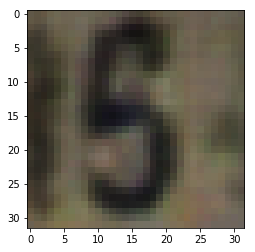

In [0]:
# sample latent variable for interpolation
latent_variables_1 = Variable(torch.randn(1, z_size, device=device))
createSample(G, 'GAN_interpolation/original_1.png', latent_variables_1, True)

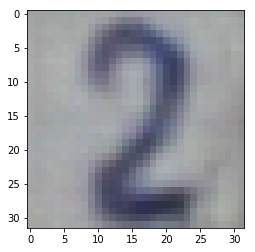

In [0]:
# sample latent variable for interpolation
latent_variables_2 = Variable(torch.randn(1, z_size, device=device))
createSample(G, 'GAN_interpolation/original_2.png', latent_variables_2, True)

In [0]:
# z interpolation
for i in range(11):
    alpha = i * 0.1
    z_interpolated = alpha * latent_variables_1 + (1 - alpha) * latent_variables_2
    createSample(G, f'GAN_interpolation/z_interpolated_alpha_{i}.png', z_interpolated)

In [0]:
x1 = G(latent_variables_1)
x2 = G(latent_variables_2)
x1 = x1.squeeze()
x2 = x2.squeeze()
x1 = x1 * 0.5 + 0.5
x2 = x2 * 0.5 + 0.5

# x interpolation
for i in range(11):
    alpha = i * 0.1
    x_interpolated = alpha * x1 + (1 - alpha) * x2
    torchvision.utils.save_image(x_interpolated, f'GAN_interpolation/x_interpolated_alpha_{i}.png')